In [1]:
import os
import pickle
from torchvision import transforms
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2

%load_ext autoreload
%autoreload 2

/home/jmorales/miniconda3/envs/stvqa_rl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/data/users/jmorales/svhn/"

# Load splits data
with open(data_dir + "train_data.pkl", "rb") as f:
    train_data = pickle.load(f)
with open(data_dir + "val_data.pkl", "rb") as f:
    val_data = pickle.load(f)
with open(data_dir + "test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

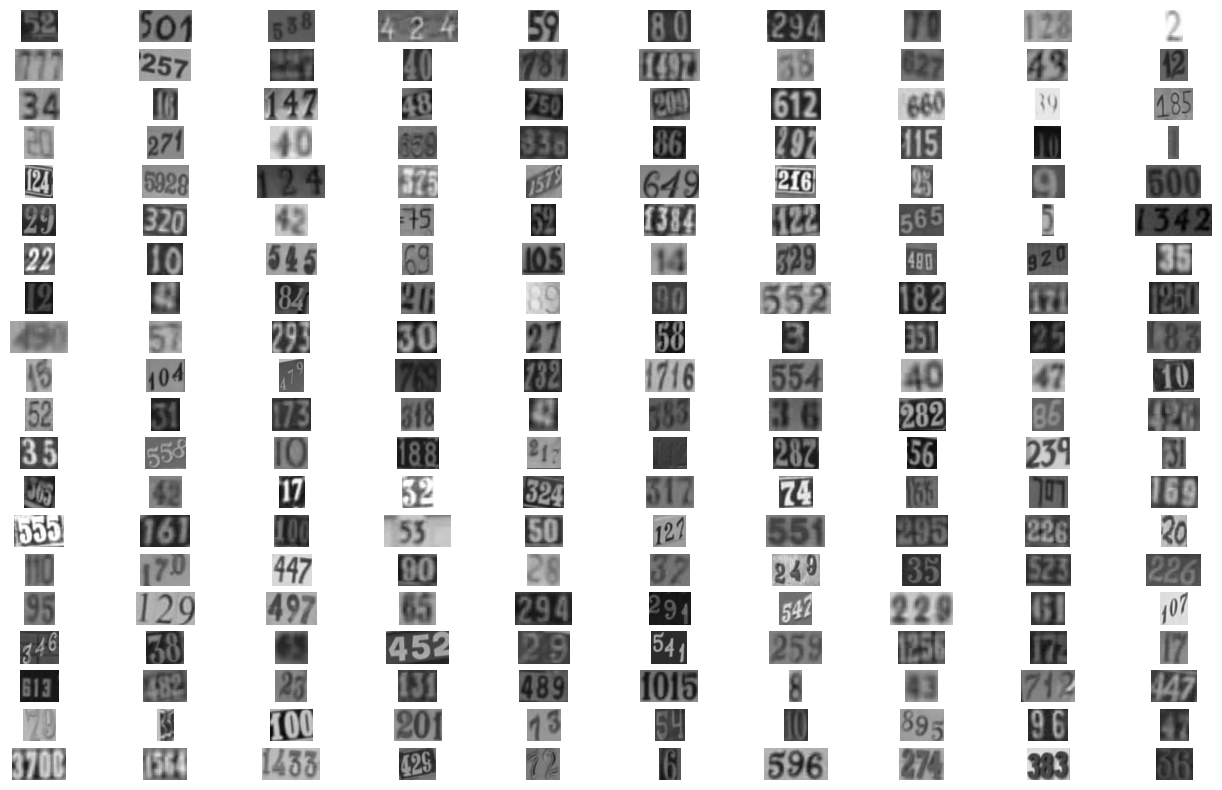

In [9]:
ncols, nrows = 10, 20
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 10))

rand_idx = np.random.randint(low=0, high=len(train_data), size=(nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        sample = train_data[rand_idx[i, j]]
        
        img_path = os.path.join(data_dir, sample["dataset_split"], sample["filename"])
        img = Image.open(img_path).convert('L').convert("RGB")
        img_draw = ImageDraw.Draw(img)
        
        w, h = img.size
        bboxes = sample["boxes"]

        # Get smaller bounding box that contain all digit bounding boxes
        x1 = min([i["left"] for i in bboxes])
        y1 = min([i["top"] for i in bboxes])
        x2 = max([i["left"] + i["width"] for i in bboxes])
        y2 = max([i["top"] + i["height"] for i in bboxes])
        
        # expand bbox
        """x1 = int(max(0, x1 - 0.5*(x2-x1)))
        y1 = int(max(0, y1 - 0.5*(y2-y1)))
        x2 = int(min(w, x2 + 0.5*(x2-x1)))
        y2 = int(min(h, y2 + 0.5*(y2-y1)))"""
        
        #img_draw.rectangle(((x1, y1), (x2, y2)), outline ="red", width=1)        
        img = img.crop((x1, y1, x2, y2))
        
        ax[i, j].axis("off")
        ax[i, j].imshow(img, cmap="gray")
        
plt.show()   

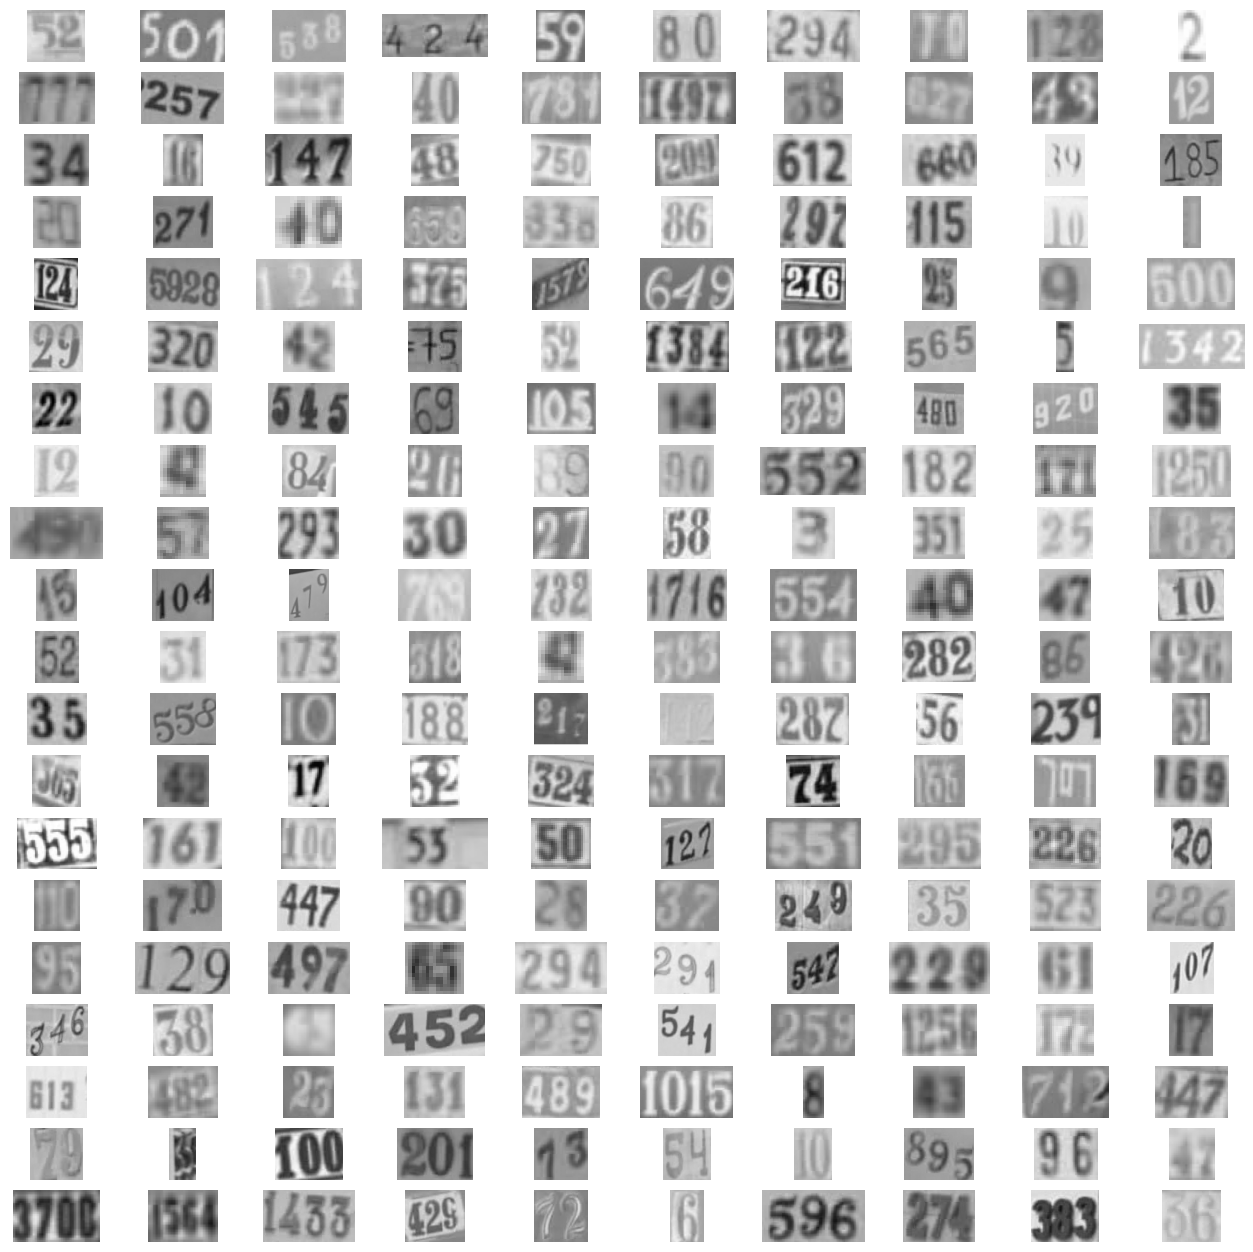

In [10]:
import cv2

ncols, nrows = 10, 20
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16))

#rand_idx = np.random.randint(low=0, high=len(train_data), size=(nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        sample = train_data[rand_idx[i, j]]
        
        img_path = os.path.join(data_dir, sample["dataset_split"], sample["filename"])
        img = Image.open(img_path).convert('L')
        
        
        
        img_draw = ImageDraw.Draw(img)
        w, h = img.size
        bboxes = sample["boxes"]

        # Get smaller bounding box that contain all digit bounding boxes
        x1 = min([i["left"] for i in bboxes])
        y1 = min([i["top"] for i in bboxes])
        x2 = max([i["left"] + i["width"] for i in bboxes])
        y2 = max([i["top"] + i["height"] for i in bboxes])
        
        # expand bbox
        """x1 = int(max(0, x1 - 0.5*(x2-x1)))
        y1 = int(max(0, y1 - 0.5*(y2-y1)))
        x2 = int(min(w, x2 + 0.5*(x2-x1)))
        y2 = int(min(h, y2 + 0.5*(y2-y1)))"""
        
        #img_draw.rectangle(((x1, y1), (x2, y2)), outline ="red", width=1)        
        img = img.crop((x1, y1, x2, y2))
        

        open_cv_img = np.array(img, dtype="uint8")
        
        mean_corner_values = (
            open_cv_img[:2, :2].mean() + open_cv_img[:-2, :2].mean() + open_cv_img[:-2, :-2].mean() + open_cv_img[:2, :-2].mean()
            ) / 4
        
        mean_background_color = np.mean([open_cv_img[:, 0].mean(), open_cv_img[:, -1].mean(), open_cv_img[0, :].mean(), open_cv_img[-1, :].mean()])
        
        if mean_background_color < 0.5*255:
            open_cv_img = 255 - open_cv_img
        
        """open_cv_img = cv2.adaptiveThreshold(open_cv_img, 255,
	        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)"""
        
        img = Image.fromarray(open_cv_img).convert("RGB")
        
        ax[i, j].axis("off")
        ax[i, j].imshow(img, cmap="gray")
        
plt.show()   

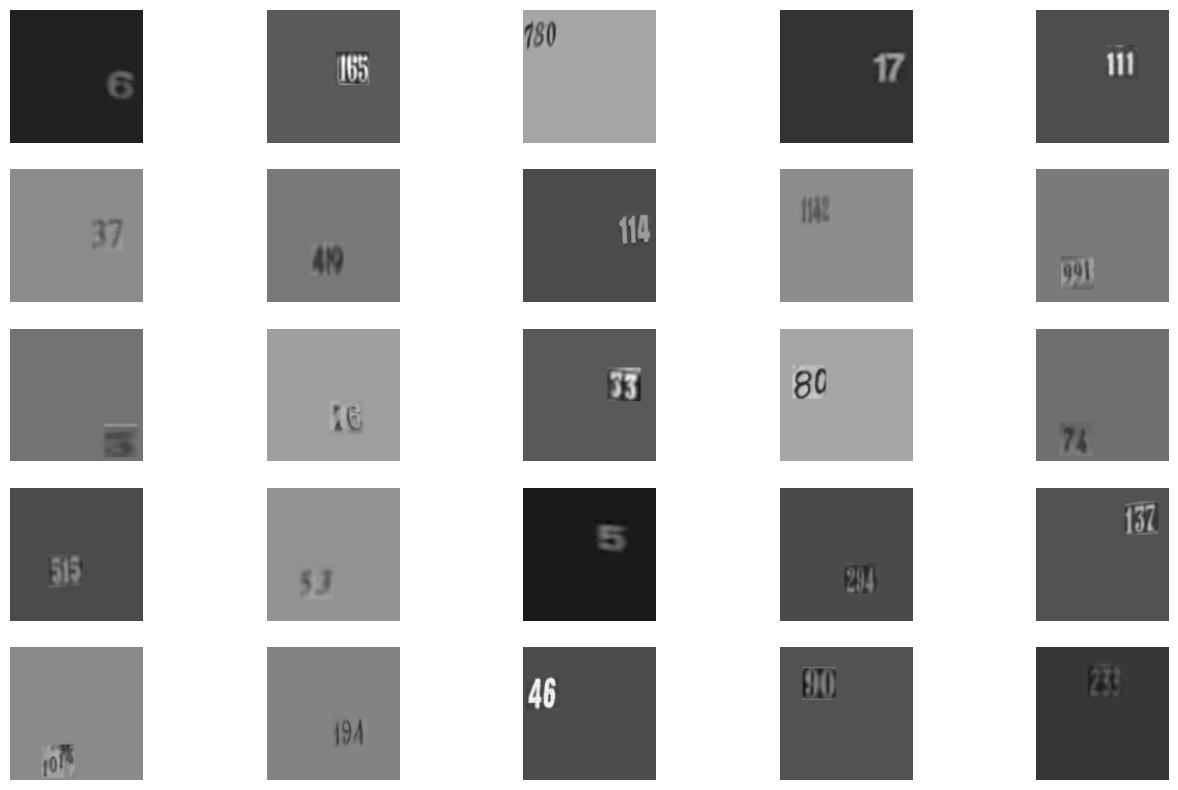

In [11]:
ncols, nrows = 5, 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 10))

rand_idx = np.random.randint(low=0, high=len(train_data), size=(nrows, ncols))

train_trans = transforms.Compose([
            transforms.Resize((128, 128))])


proportion_img = 0.25

for i in range(nrows):
    for j in range(ncols):
        sample = train_data[rand_idx[i, j]]
        
        img_path = os.path.join(data_dir, sample["dataset_split"], sample["filename"])
        img = Image.open(img_path).convert('L')
        
        w, h = img.size
        bboxes = sample["boxes"]

        # Get smaller bounding box that contain all digit bounding boxes
        x1 = int(min([i["left"] for i in bboxes]))
        y1 = int(min([i["top"] for i in bboxes]))
        x2 = int(max([i["left"] + i["width"] for i in bboxes]))
        y2 = int(max([i["top"] + i["height"] for i in bboxes]))
        
        bbox_img = np.array(img)[y1:y2, x1:x2]
        h, w = bbox_img.shape
        
        
        mean_background_color = np.mean([bbox_img[:, 0].mean(), bbox_img[:, -1].mean(), bbox_img[0, :].mean(), bbox_img[-1, :].mean()])
        
        """
        # invert colors if background dark
        if mean_background_color < 0.5*255:
            bbox_img = 255 - bbox_img
            mean_background_color = 255 - mean_background_color"""
        
        new_img = np.full((int(h/proportion_img), int(w/proportion_img)), fill_value=mean_background_color)
        
        rand_x, rand_y = np.random.randint(0, new_img.shape[1]-w), np.random.randint(0, new_img.shape[0]-h)
        
        new_img[rand_y:rand_y+bbox_img.shape[0], rand_x:rand_x+bbox_img.shape[1]] = bbox_img
        # expand bbox
        """x1 = int(max(0, x1 - 0.5*(x2-x1)))
        y1 = int(max(0, y1 - 0.5*(y2-y1)))
        x2 = int(min(w, x2 + 0.5*(x2-x1)))
        y2 = int(min(h, y2 + 0.5*(y2-y1)))"""
        
        img = Image.fromarray(new_img)
        
        img = train_trans(img)
        
        
        ax[i, j].axis("off")
        ax[i, j].imshow(img, cmap="gray")
        
plt.show()   

(13, 8, 64, 39) [{'height': 27.0, 'label': 1.0, 'left': 13.0, 'top': 9.0, 'width': 11.0}, {'height': 27.0, 'label': 3.0, 'left': 22.0, 'top': 12.0, 'width': 14.0}, {'height': 27.0, 'label': 3.0, 'left': 35.0, 'top': 8.0, 'width': 15.0}, {'height': 27.0, 'label': 1.0, 'left': 51.0, 'top': 10.0, 'width': 13.0}] (31, 51)
(39, 13, 66, 65) [{'height': 52.0, 'label': 2.0, 'left': 39.0, 'top': 13.0, 'width': 27.0}] (52, 27)
(10, 9, 54, 36) [{'height': 26.0, 'label': 9.0, 'left': 10.0, 'top': 10.0, 'width': 13.0}, {'height': 26.0, 'label': 7.0, 'left': 26.0, 'top': 9.0, 'width': 13.0}, {'height': 26.0, 'label': 4.0, 'left': 40.0, 'top': 9.0, 'width': 14.0}] (27, 44)
(10, 14, 56, 50) [{'height': 35.0, 'label': 2.0, 'left': 10.0, 'top': 14.0, 'width': 24.0}, {'height': 35.0, 'label': 4.0, 'left': 35.0, 'top': 15.0, 'width': 21.0}] (36, 46)
(9, 8, 66, 54) [{'height': 39.0, 'label': 6.0, 'left': 9.0, 'top': 8.0, 'width': 18.0}, {'height': 39.0, 'label': 9.0, 'left': 29.0, 'top': 8.0, 'width': 18.0

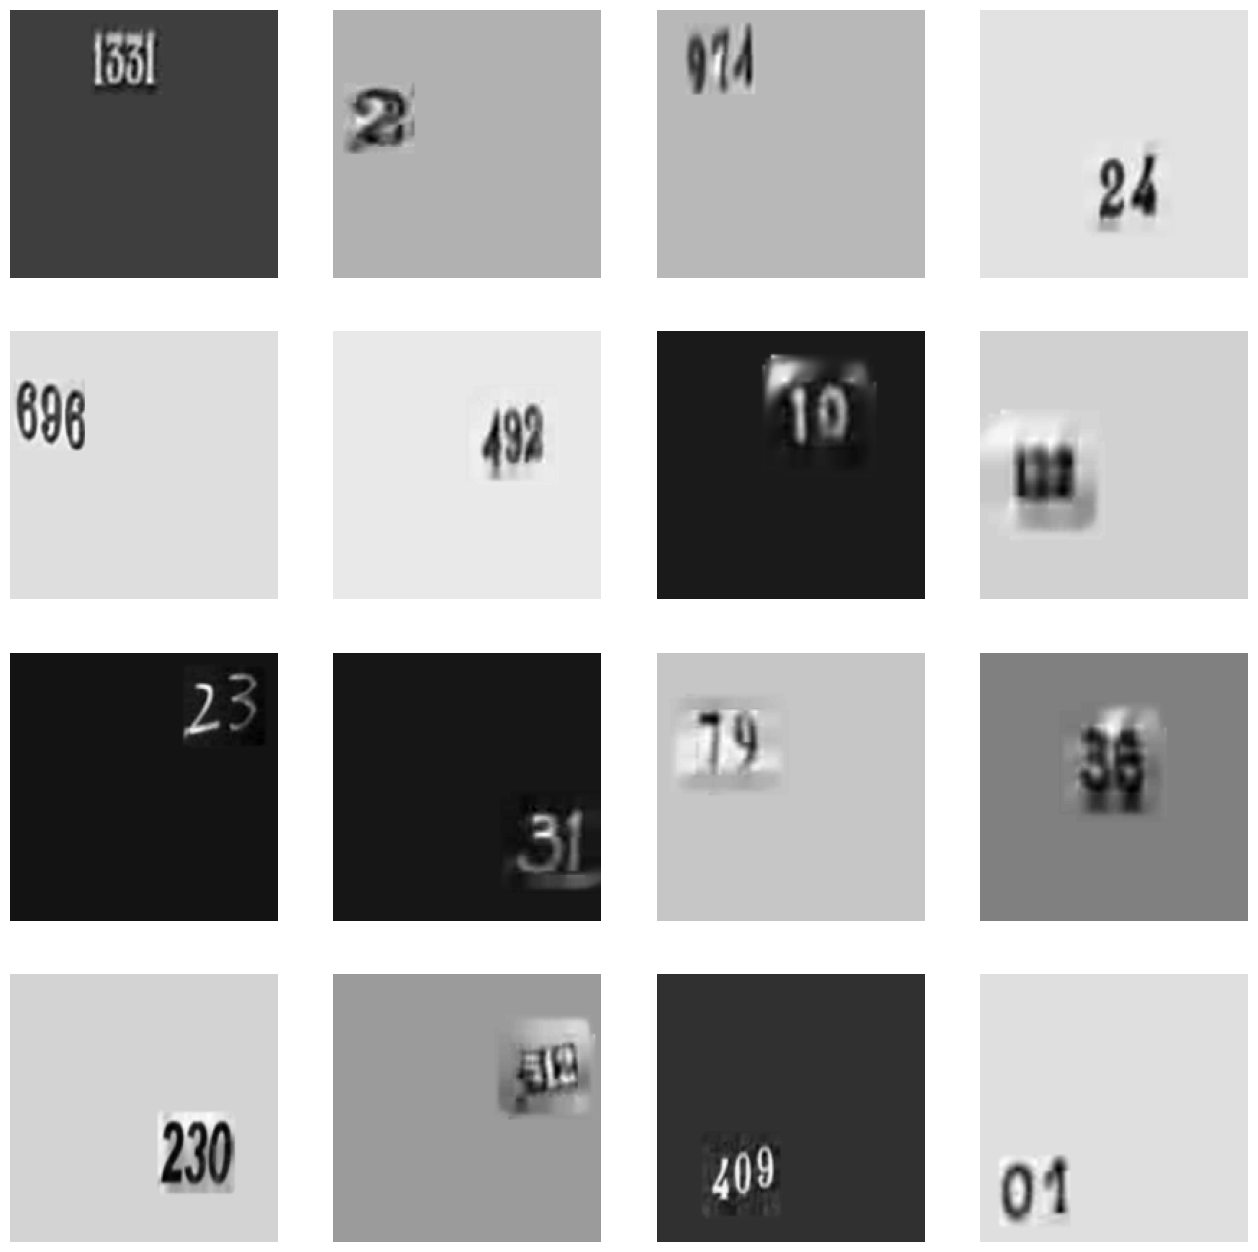

In [9]:
ncols, nrows = 4, 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16))

#rand_idx = np.random.randint(low=0, high=len(train_data), size=(nrows, ncols))

SIZE = 186
trans = transforms.Compose([
            transforms.Resize((SIZE, SIZE))])


proportion_img = 1.3*SIZE/64#0.5

for i in range(nrows):
    for j in range(ncols):
        # get random sample
        sample = train_data[rand_idx[i, j]]
        
        # open image
        img_path = os.path.join(data_dir, sample["dataset_split"], sample["filename"])
        img = Image.open(img_path).convert('L')
        w, h = img.size
        
        # get digit bboxes
        bboxes = sample["boxes"]

        # Get smaller bounding box that contain all digit bounding boxes
        x1 = int(min([i["left"] for i in bboxes]))
        y1 = int(min([i["top"] for i in bboxes]))
        x2 = int(max([i["left"] + i["width"] for i in bboxes]))
        y2 = int(max([i["top"] + i["height"] for i in bboxes]))
        
        # get matrix containing the bbox
        bbox_img = np.array(img)[y1:y2, x1:x2]
        h, w = bbox_img.shape
        
        print((x1, y1, x2, y2), bboxes, bbox_img.shape)
        
        # compute the mean background color and create an empty background image with random noise
        mean_background_color = np.median(
            np.concatenate([bbox_img[:, 0], bbox_img[:, -1], bbox_img[0, :], bbox_img[-1, :]]))
        
        """
        # invert colors if background dark
        if mean_background_color < 0.5*255:
            bbox_img = 255 - bbox_img
            mean_background_color = 255 - mean_background_color"""
        
        new_img = (
            np.random.normal(
                loc=mean_background_color/255, scale=0.0, 
                size=(int(h*proportion_img), int(w*proportion_img))#(int(h/proportion_img), int(w/proportion_img))
                )*255).astype("uint8")
        new_img = np.clip(new_img, a_min=0, a_max=255)
        
        # randomly paste the bbox on the background image or place in the center for inference
        if True:
            rand_x, rand_y = np.random.randint(0, new_img.shape[1]-w), np.random.randint(0, new_img.shape[0]-h)
        else:
            rand_x, rand_y= int((new_img.shape[1]-w)/2), int((new_img.shape[0]-h)/2)
            
        new_img[rand_y:rand_y+h, rand_x:rand_x+w] = bbox_img
        
        # to blur borders, we create a mask around the bbox to do inpainting
        mask = np.zeros(new_img.shape, dtype="uint8")
        border_size = 10
        mask[rand_y-border_size:rand_y+h+border_size, rand_x-border_size:rand_x+w+border_size] = 1
        mask[rand_y:rand_y+h, rand_x:rand_x+w] = 0
        
        new_img = cv2.inpaint(new_img, mask, 5, cv2.INPAINT_NS)
        
        # convert to PIL and resize image
        img = Image.fromarray(new_img)
        img = trans(img)
        
        ax[i, j].axis("off")
        ax[i, j].imshow(img, cmap="gray")
        
plt.show()   

#### Visualize the different steps of the preprocessing method

In [30]:
current_sample = train_data[45]

# Define transforms
train_trans = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((64, 64)),
            transforms.RandomCrop((54, 54))])

# Read image
img_path = os.path.join(data_dir, current_sample["dataset_split"], current_sample["filename"])
img = Image.open(img_path)


w, h = img.size
bboxes = current_sample["boxes"]

img_boxes = img.copy()
img_draw = ImageDraw.Draw(img_boxes)
for box in bboxes:
    shape = [(box["left"], box["top"]), (box["left"]+box["width"], box["top"]+box["height"])]
    img_draw.rectangle(shape, outline ="green")

# Get smaller bounding box that contain all digit bounding boxes
x1 = min([i["left"] for i in bboxes])
y1 = min([i["top"] for i in bboxes])
x2 = max([i["left"] + i["width"] for i in bboxes])
y2 = max([i["top"] + i["height"] for i in bboxes])

img_draw.rectangle(((x1, y1), (x2, y2)), outline ="orange")

# Expand this bbox by 30% in both x and y axis
x1 = int(max(0, x1 - 0.15*(x2-x1)))
y1 = int(max(0, y1 - 0.15*(y2-y1)))
x2 = int(min(w, x2 + 0.15*(x2-x1)))
y2 = int(min(h, y2 + 0.15*(y2-y1)))

img_draw.rectangle(((x1, y1), (x2, y2)), outline ="red")

# Crop image
img_cropped = img.crop((x1, y1, x2, y2))


# Apply transforms (Resize + Normalize)
img_trans = train_trans(img_cropped)

# Get labels, we add an "end sequence" label (0) at the end
labels = [int(box["label"]) for box in current_sample["boxes"]] + [0]

# Max length is 5 (as in the paper)
labels = labels[:5]

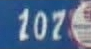

In [31]:
img

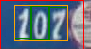

In [32]:
img_boxes

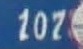

In [33]:
img_cropped

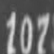

In [25]:
img_trans

#### Plot on the amount of samples per number of digits that appear in an image

In [8]:
# get number of digits per image in ALL the dataset
num_digits = []
for data in [train_data, val_data, test_data]:
    num_digits += [len(i["boxes"]) for i in data]

/tmp/ipykernel_2846592/3928420966.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None]+x.tolist())


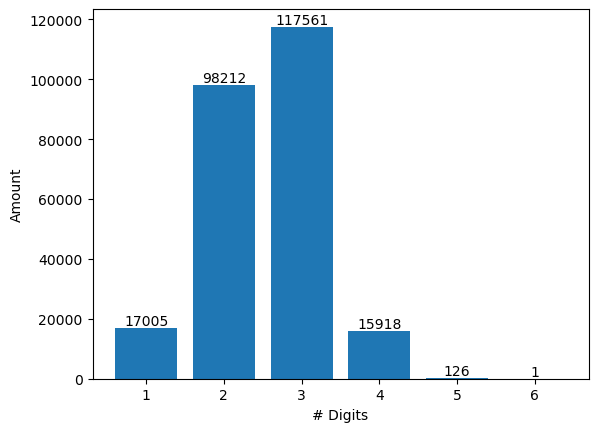

In [9]:
x, y = np.unique(num_digits, return_counts=True)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.bar(x, y)
ax.set_xlabel('# Digits')
ax.set_ylabel('Amount')
ax.set_xticklabels([None]+x.tolist())

# Make some labels.
labels = [f"{i}" for i in y]
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    );